# Importing Libraries

In [8]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [9]:
# %run "Git.ipynb".ipynb

In [10]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [13]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [14]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [16]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [17]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [18]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [19]:
# trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))


In [20]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [21]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [22]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_56528\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [23]:
book_cost.iloc[-1]

UMAUSDT          4.098270
EURUSDT          1.083068
PEPEUSDT         0.000015
FETUSDT          2.292907
XRPUSDT          0.551117
INJUSDT               NaN
TNSRUSDT         0.860996
ETHUSDT       3654.535009
SOLUSDT        157.056383
USDTUSDT         0.000011
OMUSDT           1.129914
LPTUSDT         23.209038
JASMYUSDT        0.030287
BNBUSDT        680.981177
NEARUSDT         8.272700
ENSUSDT         23.729381
BBUSDT           0.516922
BTCUSDT      70298.808206
MKRUSDT       2786.582522
NOTUSDT          0.019619
RNDRUSDT        11.186443
TRXUSDT          0.158366
ARUSDT                NaN
Name: 2025-08-09 00:37:56, dtype: float64

In [24]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [25]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [355]:
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Average Cost,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2261.97,2101.17,1.00,-100.45,-60.35,-160.80,-7.11
BTCUSDT,70298.81,622.20,994.44,0.47,2.81,372.24,375.05,16.58
SOLUSDT,157.06,281.20,323.01,0.15,0.00,41.81,41.81,1.85
ETHUSDT,3654.54,253.39,293.23,0.14,0.00,39.83,39.83,1.76
JASMYUSDT,0.03,387.46,192.41,0.09,0.00,-195.05,-195.05,-8.62
TRXUSDT,0.16,76.87,171.54,0.08,-12.30,94.67,82.37,3.64
OMUSDT,1.13,526.32,109.28,0.05,0.00,-417.04,-417.04,-18.44
BNBUSDT,680.98,14.08,17.27,0.01,-10.65,3.19,-7.46,-0.33
BBUSDT,0.52,0.01,0.00,0.00,-84.82,-0.00,-84.82,-3.75
PEPEUSDT,0.00,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.70


In [27]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

129

In [28]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [29]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [30]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [31]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [32]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [33]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [35]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 16ed34bd851d830cd26e7f7f782ab15c2714666b)
✅ File pushed/updated successfully!


In [36]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [37]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [38]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [39]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 97942b2bdecdf27b56049298d9ba4b2594f32717)
✅ File pushed/updated successfully!


In [40]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [41]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [42]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [43]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [44]:
# pnl_history['Total']

In [45]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [46]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [47]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [48]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)#+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [49]:
pnl_history['Total']

2024-09-23   -260.527866
2024-09-24   -237.024528
2024-09-25   -254.283766
2024-09-26   -168.584549
2024-09-27   -152.065428
                 ...    
2025-08-16     41.630358
2025-08-17     47.816763
2025-08-18     -3.595074
2025-08-19    -77.621234
2025-08-20     -9.865432
Name: Total, Length: 332, dtype: float64

<Axes: >

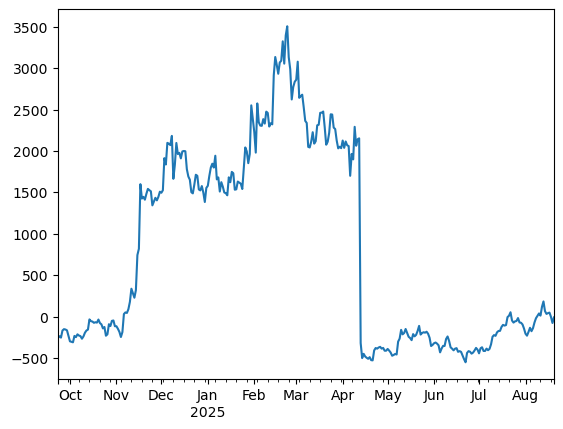

In [50]:
pnl_history['Total'].plot()

In [51]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:].cumsum()

2025-07-21     16.674338
2025-07-22     58.566044
2025-07-23    -41.019863
2025-07-24    -66.189285
2025-07-25    -51.577973
2025-07-26    -46.653821
2025-07-27    -11.529995
2025-07-28    -64.302994
2025-07-29    -68.038187
2025-07-30    -88.353308
2025-07-31   -138.121275
2025-08-01   -200.606115
2025-08-02   -224.266112
2025-08-03   -179.436893
2025-08-04   -128.996803
2025-08-05   -170.016857
2025-08-06   -133.603468
2025-08-07    -65.164201
2025-08-08    -13.078498
2025-08-09     15.560151
2025-08-10     44.140307
2025-08-11     18.014249
2025-08-12    124.425731
2025-08-13    189.466005
2025-08-14     72.521187
2025-08-15     38.732485
2025-08-16     48.148569
2025-08-17     54.334974
2025-08-18      2.923137
2025-08-19    -71.103023
2025-08-20     -3.347221
Name: Total, dtype: float64

In [52]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-371.0142984064944, -950.5160328166935)

In [53]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [54]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [55]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [56]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [57]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [58]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [59]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

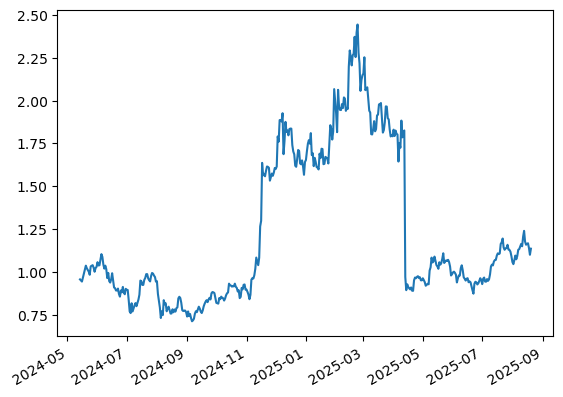

In [60]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

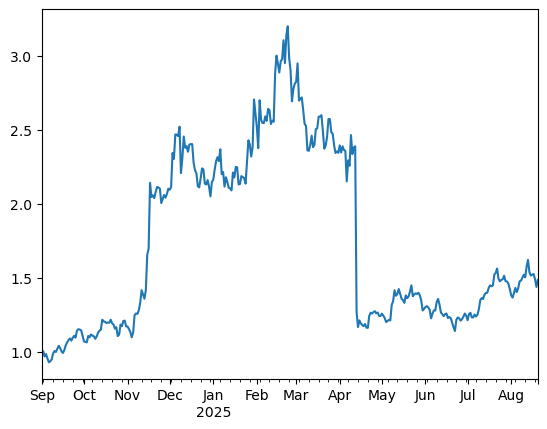

In [61]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [63]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [66]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [67]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [70]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.4294
TRXUSDT,0.1900
WBTCUSDT,0.1210
BTCUSDT,0.1043
XRPUSDT,0.0815
ADAUSDT,0.0382
OMUSDT,0.0357
AVAXUSDT,0.0000
JASMYUSDT,0.0000
HBARUSDT,0.0000


In [71]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.397662
WBTCUSDT,0.247850
TRXUSDT,0.207354
XRPUSDT,0.109348
OMUSDT,0.037786


In [72]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

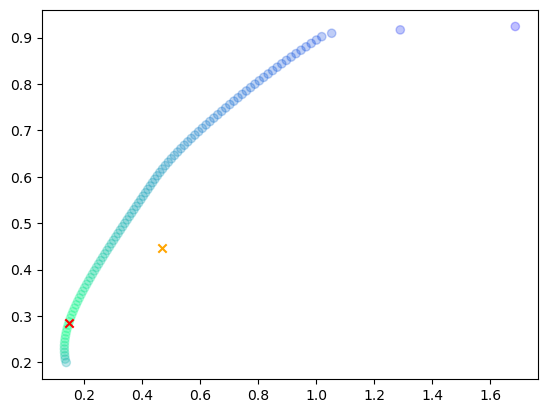

In [73]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [74]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [75]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,994.2967,0.4731,0.0000,0.4731
SOLUSDT,323.0855,0.1537,0.0000,0.1537
ETHUSDT,293.5299,0.1397,0.0000,0.1397
JASMYUSDT,192.4052,0.0915,0.0000,0.0915
TRXUSDT,171.8275,0.0818,0.0289,0.0529
OMUSDT,109.4177,0.0521,0.0051,0.0470
BNBUSDT,17.2972,0.0082,0.0546,-0.0464
BBUSDT,0.0015,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0026,-0.0026
PAXGUSDT,0.0000,0.0000,0.7460,-0.7460


### Current results

In [77]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [78]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.613726
TRXUSDT,0.386274


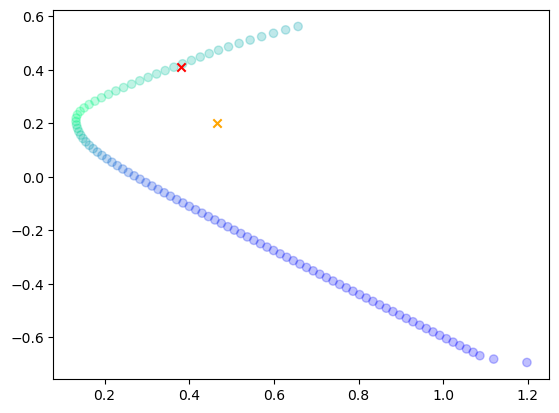

In [79]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [80]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,994.2967,0.4731,0.6137,-0.1407
SOLUSDT,323.0855,0.1537,0.0000,0.1537
ETHUSDT,293.5299,0.1397,0.0000,0.1397
JASMYUSDT,192.4052,0.0915,0.0000,0.0915
TRXUSDT,171.8275,0.0818,0.3863,-0.3045
OMUSDT,109.4177,0.0521,0.0000,0.0521
BNBUSDT,17.2972,0.0082,0.0000,0.0082
BBUSDT,0.0015,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [82]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [83]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

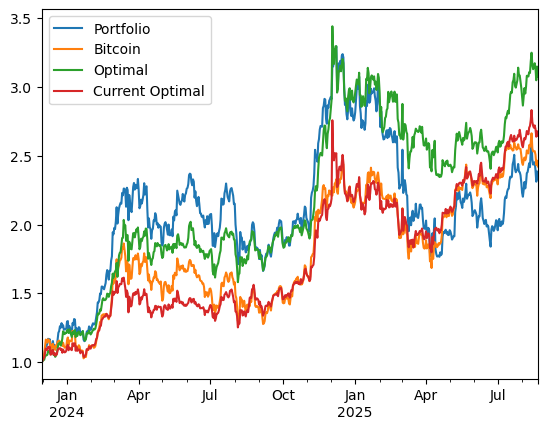

In [84]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [85]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

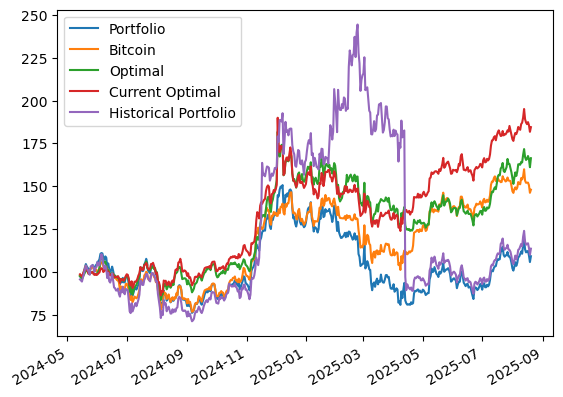

In [86]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

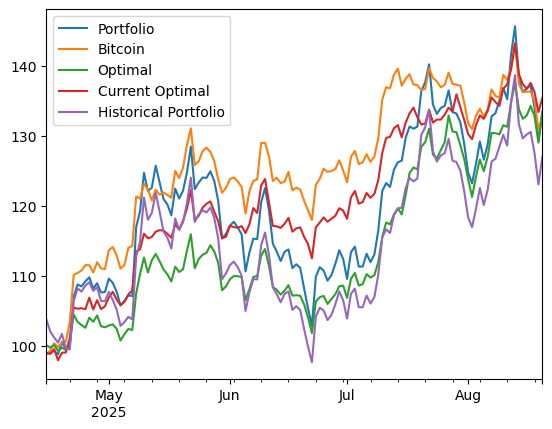

In [351]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

## Volatilities

In [89]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.376044
 dtype: float64,
 0.37634036414997557)

In [90]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.465623
 dtype: float64,
 0.46562256427760684)

In [91]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.467299
Bitcoin            0.406919
Optimal            0.376340
Current Optimal    0.373310
dtype: float64

In [92]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5316087690869803

In [93]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-0.5096140216327272

<Axes: >

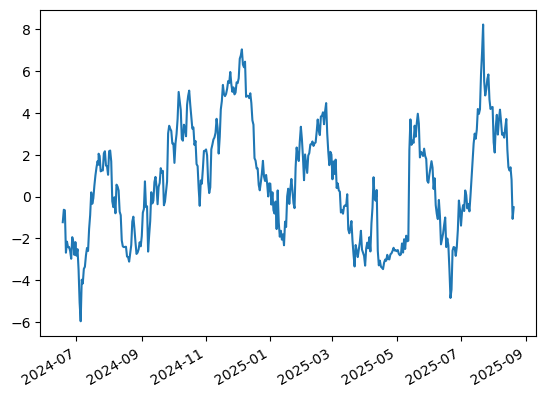

In [94]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [95]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.4310858844476713

## Risk Contribution

In [97]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,75.1389,0.3981,0.2167,0.1814
WBTCUSDT,35.4459,0.2078,0.0705,0.1373
TRXUSDT,28.3073,0.1961,0.1036,0.0925
XRPUSDT,17.8960,0.1309,0.0406,0.0903
OMUSDT,-34.8726,0.0671,0.0286,0.0385
Portfolio,121.9156,1.0000,0.4600,0.5400


In [98]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,38.817598,0.529693,0.446018,0.083675
BTCUSDT,34.268322,0.470307,0.386633,0.083675
Portfolio,73.085920,1.000000,0.832651,0.167349


In [99]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,26.508246,0.355507,0.154113,0.201394
TRXUSDT,8.120597,0.042211,0.013003,0.029209
ETHUSDT,0.503684,0.156042,0.032924,0.123118
BNBUSDT,0.216730,0.006737,0.000078,0.006659
SOLUSDT,-3.317162,0.197807,0.051503,0.146304
JASMYUSDT,-6.254752,0.160905,0.040954,0.119951
OMUSDT,-7.869482,0.080791,0.035465,0.045326
Portfolio,17.907860,1.000000,0.328039,0.671961


# Value At Risk

## Historical

### Optimal Weights

In [103]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.06398470481117224, -0.08092884597142477)

### Current Weights

In [105]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.0800762559150058, -0.09738063393526483)

In [106]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [107]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.031222
SOLUSDT     -0.012081
ETHUSDT     -0.012272
JASMYUSDT   -0.015602
TRXUSDT     -0.003974
OMUSDT      -0.002870
BNBUSDT     -0.000677
BBUSDT      -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.078699
Name: 2025-03-09 00:00:00, dtype: float64

In [108]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025702
SOLUSDT     -0.018303
ETHUSDT     -0.014091
JASMYUSDT   -0.012298
TRXUSDT     -0.004254
OMUSDT      -0.018984
BNBUSDT     -0.000636
BBUSDT       0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.094267
dtype: float64

## Parametric

### Optimal Weights

In [111]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.055151228209714756, -0.06830840389228762)

### Current Weights

In [113]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.06823519013185964, -0.08451374662900211)

## Multivariate

### Optimal Weights

In [116]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05317752259773494, -0.060831848726939974)

### Current Weights

In [118]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06725256983226087, -0.07628412294990147)

In [119]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.024275
SOLUSDT     -0.013622
ETHUSDT     -0.010563
JASMYUSDT   -0.010748
TRXUSDT     -0.002315
OMUSDT      -0.005369
BNBUSDT     -0.000405
Portfolio   -0.067296
dtype: float64

In [120]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.025333
SOLUSDT     -0.013017
ETHUSDT     -0.010055
JASMYUSDT   -0.011536
TRXUSDT     -0.002316
OMUSDT      -0.005380
BNBUSDT     -0.000425
Portfolio   -0.068063
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [124]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05177146324127101, -0.05861632142533748)

### Current Weights

In [126]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06758947961502525, -0.07687686779134817)

In [127]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [130]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05240665167161366, -0.061299821327461756)

### Current Weights

In [132]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06839240824472259, -0.07916433686561843)

In [133]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [136]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08607203983997483, -0.10127570714097796)

### Current Weights

In [138]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08511394399478892, -0.10154744487373395)

In [139]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [142]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [143]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05549868236533019, -0.06441753253508851)

### Current Weights

In [145]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06891341402279066, -0.07924470581172964)

In [146]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [147]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.026893,-0.023891,-0.016800,-0.024275,-0.024414
SOLUSDT,-0.011513,-0.013473,-0.009546,-0.013622,-0.013159
ETHUSDT,-0.007766,-0.010260,-0.007870,-0.010563,-0.011292
JASMYUSDT,-0.003696,-0.010963,-0.008174,-0.010748,-0.011354
TRXUSDT,-0.002067,-0.002738,-0.002048,-0.002315,-0.003161
OMUSDT,-0.005421,-0.005708,-0.004448,-0.005369,-0.005554
BNBUSDT,0.000056,-0.000416,-0.000321,-0.000405,-0.000458
Portfolio,-0.057301,-0.067449,-0.049206,-0.067296,-0.069392


In [148]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.029624,-0.024707,-0.016884,-0.025333,-0.024387
SOLUSDT,-0.012598,-0.013722,-0.009545,-0.013017,-0.013847
ETHUSDT,-0.008143,-0.010471,-0.007969,-0.010055,-0.011368
JASMYUSDT,-0.001726,-0.010548,-0.008500,-0.011536,-0.011412
TRXUSDT,-0.002396,-0.003134,-0.002170,-0.002316,-0.003377
OMUSDT,-0.003791,-0.005243,-0.004294,-0.005380,-0.005504
BNBUSDT,0.000165,-0.000423,-0.000324,-0.000425,-0.000457
Portfolio,-0.058114,-0.068248,-0.049686,-0.068063,-0.070351


## VaR Violation

In [150]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.030735,-0.040381,-0.034093,0.007310
2023-12-31,-0.030735,-0.040508,-0.034745,-0.001120
2024-01-01,-0.030735,-0.040671,-0.034367,0.015222
2024-01-02,-0.030735,-0.040604,-0.033918,0.005408
2024-01-03,-0.030735,-0.041420,-0.036048,-0.019903
...,...,...,...,...
2025-08-17,-0.027948,-0.040051,-0.038035,0.010321
2025-08-18,-0.027948,-0.040412,-0.037990,-0.010960
2025-08-19,-0.028353,-0.041043,-0.041364,-0.028368
2025-08-20,-0.028353,-0.043245,-0.040950,0.032611


In [151]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.023974,-0.077754,-0.069614,-0.015840
2024-05-29,-0.017454,-0.075728,-0.068608,-0.009074
2024-05-30,-0.017454,-0.063943,-0.058780,0.022175
2024-05-31,-0.017454,-0.062844,-0.055970,0.005199
2024-06-01,-0.017454,-0.061116,-0.056039,0.015214
...,...,...,...,...
2025-08-17,-0.045915,-0.056707,-0.050055,0.002976
2025-08-18,-0.046362,-0.058678,-0.054692,-0.023332
2025-08-19,-0.047989,-0.061437,-0.062001,-0.034951
2025-08-20,-0.047989,-0.062682,-0.060552,0.032056


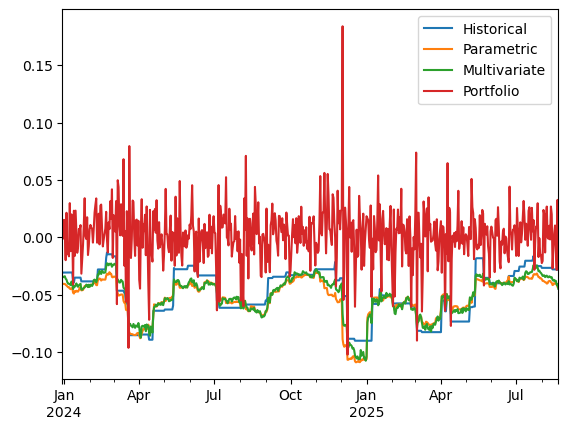

In [152]:
var_data.plot()
plt.show()

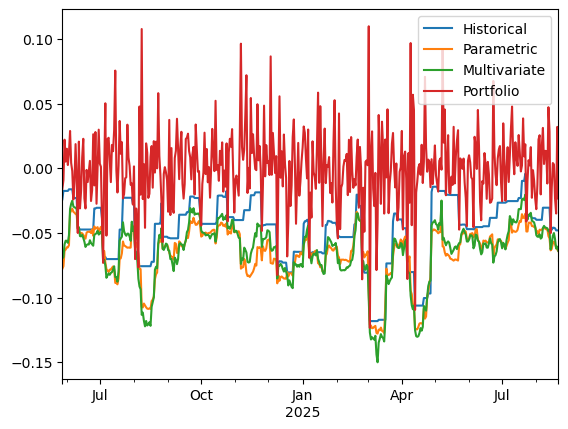

In [153]:
current_var_data.plot()
plt.show()


In [154]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031614,0.018303,0.016639
Kupiec Stat,4.892392,16.619376,18.790443
P-value,0.026975,0.000046,0.000015


In [155]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064302,0.017738,0.015521
Kupiec Stat,1.788115,13.007916,15.280111
P-value,0.181156,0.00031,0.000093


# Principal Component Analysis

## Historical PCA

In [158]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59304111, 0.22548515, 0.07576773, 0.05834706, 0.04735894])

In [159]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.059566
AVAXUSDT     0.059942
BCHUSDT      0.045491
BNBUSDT      0.026646
BTCUSDT      0.030547
DOGEUSDT     0.062452
ETHUSDT      0.044378
HBARUSDT     0.060033
JASMYUSDT    0.069555
LINKUSDT     0.056204
LTCUSDT      0.042067
OMUSDT       0.066988
PAXGUSDT     0.000513
PEPEUSDT     0.079623
SOLUSDT      0.052732
SUIUSDT      0.058237
TRXUSDT      0.017415
USDCUSDT    -0.000156
WBETHUSDT    0.044383
WBTCUSDT     0.030337
XLMUSDT      0.047242
XRPUSDT      0.045806
Name: PC1, dtype: float64

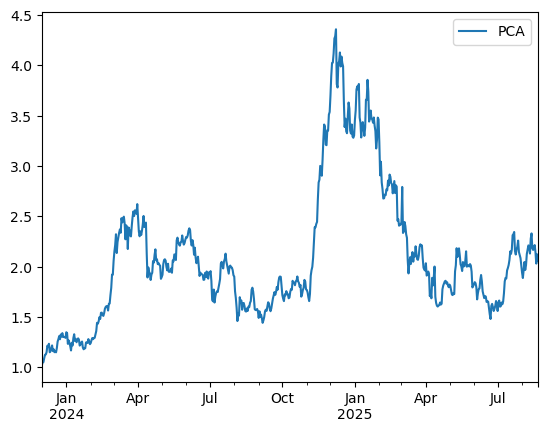

In [160]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

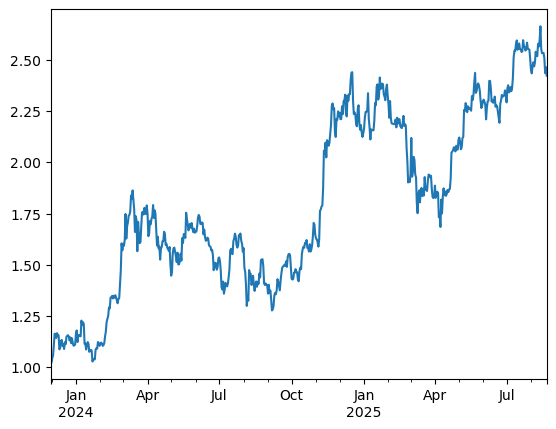

In [161]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [162]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.504821
ETHUSDT      0.505866
WBTCUSDT     0.552988
BTCUSDT      0.553681
AVAXUSDT     0.670536
SOLUSDT      0.674828
LINKUSDT     0.694359
DOGEUSDT     0.696471
BNBUSDT      0.711529
LTCUSDT      0.715762
ADAUSDT      0.734213
XRPUSDT      0.769477
BCHUSDT      0.836092
XLMUSDT      0.906102
USDCUSDT     0.952698
PAXGUSDT     0.965436
SUIUSDT      1.073704
TRXUSDT      1.085281
HBARUSDT     1.104359
dtype: float64

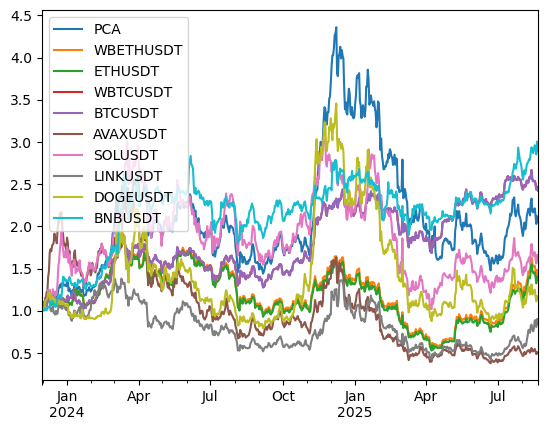

In [163]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

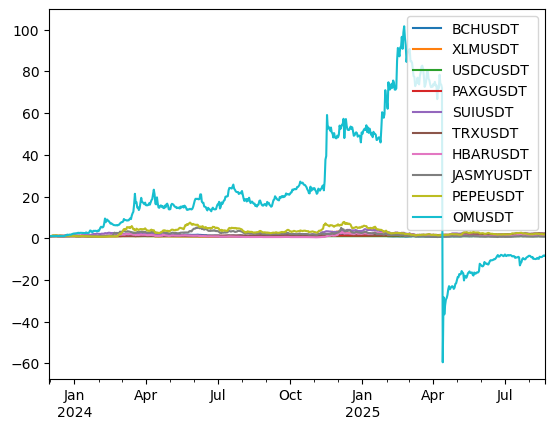

In [164]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [166]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.5255935 , 0.30135805, 0.06880688, 0.06298792, 0.04125365])

In [167]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049648
SOLUSDT      0.093443
ETHUSDT      0.081511
JASMYUSDT    0.141840
TRXUSDT      0.034411
OMUSDT       0.237716
BNBUSDT      0.051533
BBUSDT       0.171126
PEPEUSDT     0.137639
PAXGUSDT     0.001132
Name: PC1, dtype: float64

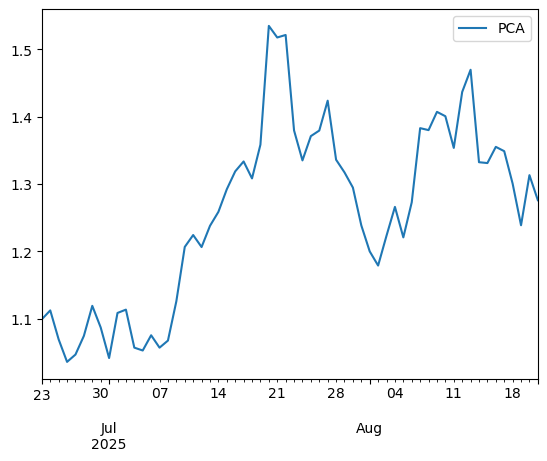

In [168]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

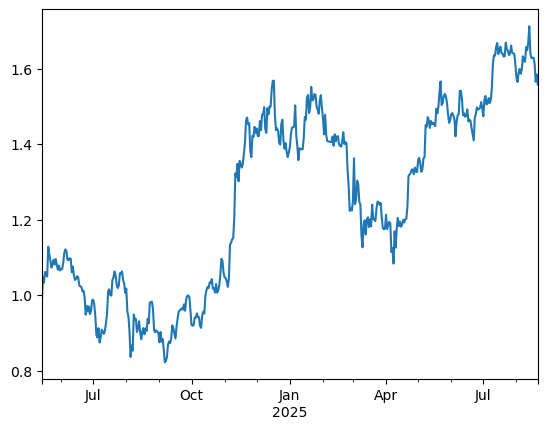

In [169]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [170]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.730963
SOLUSDT      0.769821
BTCUSDT      0.793997
BNBUSDT      0.795601
JASMYUSDT    0.972705
PEPEUSDT     1.007598
PAXGUSDT     1.059342
BBUSDT       1.081570
TRXUSDT      1.176448
dtype: float64

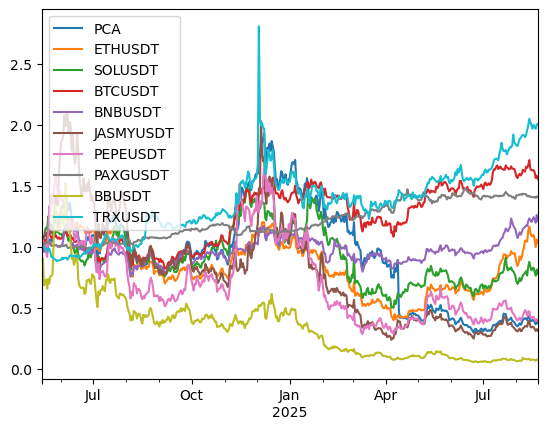

In [171]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [173]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.919715
BBUSDT       1.648731
JASMYUSDT    1.471979
SOLUSDT      1.289580
ETHUSDT      1.098255
BTCUSDT      1.000000
OMUSDT       0.996184
BNBUSDT      0.666465
TRXUSDT      0.332196
PAXGUSDT     0.029208
Name: BTCUSDT, dtype: float64

In [174]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       4.260935
JASMYUSDT    2.433514
PEPEUSDT     2.044776
SOLUSDT      1.990465
ETHUSDT      1.876014
OMUSDT       1.704495
BNBUSDT      1.129786
BTCUSDT      1.000000
TRXUSDT      0.501033
PAXGUSDT     0.090270
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [176]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [177]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.216749
PEPEUSDT,0.186302
BNBUSDT,0.176385
OMUSDT,0.148153
JASMYUSDT,0.118655
PAXGUSDT,0.089141
TRXUSDT,0.086432
SOLUSDT,0.079702
BBUSDT,0.043453
BTCUSDT,-0.028425


### Regression to PCA

In [179]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.4627025784425862

In [180]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.315976
BNBUSDT      1.124990
PCA          1.000000
ETHUSDT      0.878711
SOLUSDT      0.725344
JASMYUSDT    0.464557
PEPEUSDT     0.459397
BBUSDT       0.368608
TRXUSDT      0.283889
PAXGUSDT     0.246504
OMUSDT       0.156497
dtype: float64

In [181]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.891630
PAXGUSDT     1.679728
BNBUSDT      1.217989
PCA          1.000000
TRXUSDT      0.979661
ETHUSDT      0.887152
SOLUSDT      0.866206
PEPEUSDT     0.742746
JASMYUSDT    0.666522
OMUSDT       0.658729
BBUSDT       0.289474
dtype: float64

### Correlation Matrix

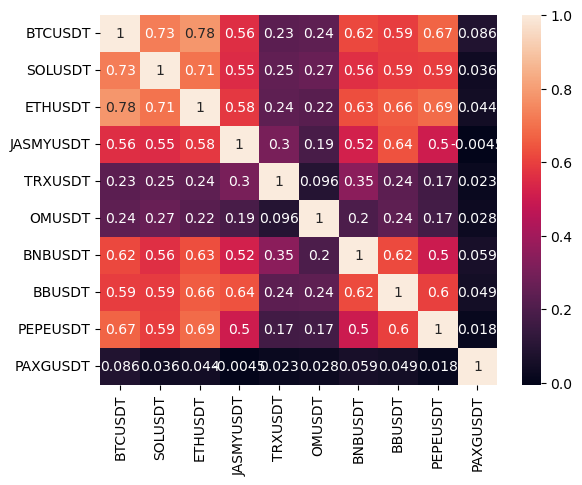

In [183]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

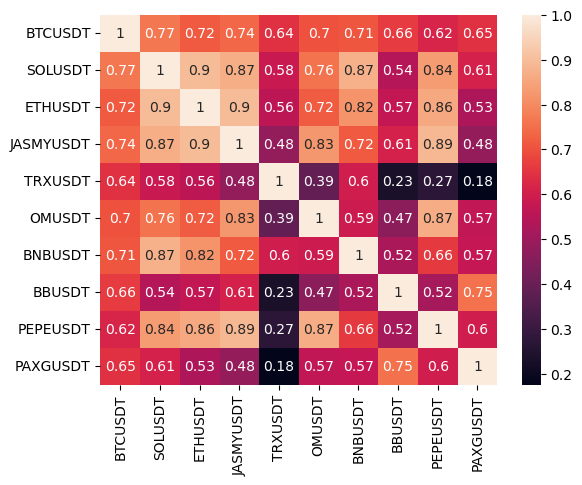

In [184]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [185]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [186]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

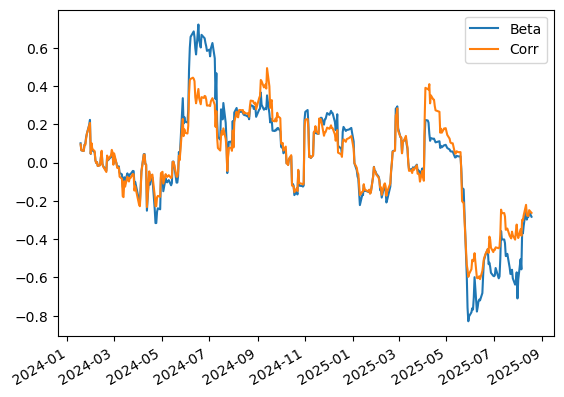

In [187]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [189]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BNBUSDT,BBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.000000,0.003604,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526887,0.176734,0.000000,0.000000,0.130357,0.000000


In [190]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [191]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,ADAUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,JASMYUSDT,LINKUSDT,...,PAXGUSDT,PEPEUSDT,SOLUSDT,SUIUSDT,TRXUSDT,USDCUSDT,WBETHUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
2025-01-13,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.761799,0.0,0.000000,0.111228,0.000000,0.0,0.000000,0.000000,0.000000,0.126972
2025-02-12,0.00000,0.000000,0.000000,0.012192,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.956052,0.0,0.000476,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-03-14,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.909521,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-04-13,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000259,0.000000,...,0.661326,0.0,0.000000,0.000000,0.338416,0.0,0.000000,0.000000,0.000000,0.000000
2025-05-13,0.00000,0.000000,0.000000,0.000000,0.034044,0.0,0.013515,0.0,0.000000,0.000000,...,0.475024,0.0,0.048527,0.062361,0.000000,0.0,0.116095,0.169228,0.000000,0.000000
2025-06-12,0.00000,0.000000,0.114887,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.830482,0.0,0.000000,0.000000,0.054631,0.0,0.000000,0.000000,0.000000,0.000000
2025-07-12,0.00000,0.000000,0.183448,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.685043,0.0,0.000000,0.000000,0.131508,0.000000
2025-08-11,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.060602,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.495196,0.0,0.320830,0.000000,0.000000,0.000000
2025-08-21,0.26014,0.023012,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.711163,...,0.000000,0.0,0.000000,0.000000,0.005686,0.0,0.000000,0.000000,0.000000,0.000000


In [192]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

TRXUSDT      0.495196
WBETHUSDT    0.320830
LTCUSDT      0.123373
ETHUSDT      0.060602
ADAUSDT      0.000000
PAXGUSDT     0.000000
Name: 2025-08-11 00:00:00, dtype: float64

<Axes: >

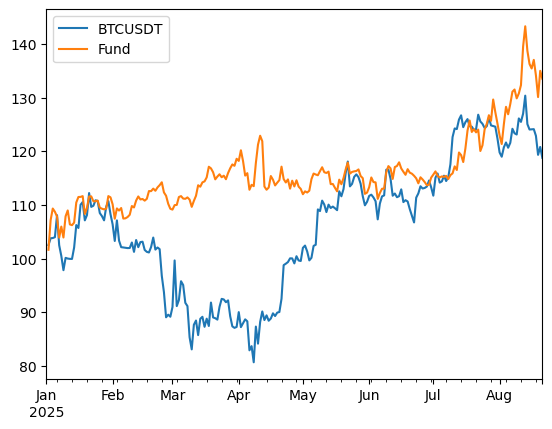

In [193]:
q=rebalanced_dynamic_quantities(data[returns_to_use.columns],rolling_optimization)
ptf=q*data[returns_to_use.columns]
comparison=pd.DataFrame()
comparison['BTCUSDT']=data['BTCUSDT']
comparison['Fund']=ptf.sum(axis=1)
((1+comparison.loc['2025'].pct_change()).cumprod()*100).plot()

In [194]:
(ptf-rebalanced_book_cost(data[returns_to_use.columns],q)).iloc[-1].sort_values(ascending=False)

PAXGUSDT     70.259116
SUIUSDT      67.254467
XRPUSDT      39.537859
TRXUSDT      36.783203
BCHUSDT      12.769523
XLMUSDT       3.338246
WBTCUSDT      0.690684
BTCUSDT       0.135659
JASMYUSDT     0.020587
USDCUSDT      0.000000
PEPEUSDT      0.000000
ADAUSDT       0.000000
AVAXUSDT      0.000000
LINKUSDT      0.000000
HBARUSDT      0.000000
DOGEUSDT      0.000000
ETHUSDT      -0.004533
WBETHUSDT    -0.024412
BNBUSDT      -0.481832
SOLUSDT      -2.234563
LTCUSDT      -5.128783
OMUSDT      -18.970496
Name: 2025-08-21 00:00:00, dtype: float64

In [195]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
